In [1]:
import tensorflow as tf 
import random
import os 
import numpy as np 
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, confusion_matrix
import pandas as pd 
import matplotlib.pyplot as plt
from tensorflow.keras import models, layers
import seaborn as sns

### Path system

In [2]:
# you need the current working directory NB: works both windows and linux 
current_working_directory = os.getcwd()
current_working_directory = os.path.dirname(current_working_directory)

# get the directory where I want to download the dataset
path_of_download = os.path.join(current_working_directory, 'Part 2', 'Datasets', "cookies_vs_chihuahua")
print(f"[DIR] The directory of the current dataset is {path_of_download}")

[DIR] The directory of the current dataset is C:\UTU\2025\Computer Vision and Sensor Fusion\Part 2\Datasets\cookies_vs_chihuahua


### Dataset function

In [3]:
# here let s do some functions that we can re-use also for other assignment
def load_the_data_and_the_labels(data_set_path: str, target_size: tuple or None = None):
    try:
        dataset, labels, name_of_the_labels = list(), list(), list() 
        # let s loop here and we try to discover how many class we have 
        for class_number, class_name in enumerate(os.listdir(data_set_path)):
            full_path_the_data = os.path.join(data_set_path, class_name)
            print(f"[WALK] I am walking into {full_path_the_data}")
            
            # add the list to nam _list
            name_of_the_labels.append(class_name)
            
            for single_image in os.listdir(f"{full_path_the_data}"):
                full_path_to_image = os.path.join(*[full_path_the_data, single_image])
                
                # add the class number 
                labels.append(class_number)
                
                if target_size is None:
                    # let s load the image 
                    image = tf.keras.utils.load_img(full_path_to_image)
                else:
                    image = tf.keras.utils.load_img(full_path_to_image, target_size=target_size)
                
                # transform PIL object in image                    
                image = tf.keras.utils.img_to_array(image)
                
                # add the image to the ds list 
                dataset.append(image)
                
        return np.array(dataset, dtype='uint8'), np.array(labels, dtype='int'), name_of_the_labels
    except Exception as ex:
        print(f"[EXCEPTION] load the data and the labels throws exceptions {ex}")
        return None, None, None

In [4]:
def fix_image_shapes(dataset):
    # Check to make sure all images have dimensions (224, 224, 3)
    fixed_dataset = []
    for i, img in enumerate(dataset):
        if img.shape != (224, 224, 3): 
            print(f"[WARNING] Image {i} has shape {img.shape}")
            img_pil = Image.fromarray(np.uint8(img * 255))  # Convert from NumPy -> PIL
            img_pil = img_pil.resize((224, 224))  # Resize Image
            img_fixed = np.array(img_pil) / 255.0  # Convert to NumPy array
            fixed_dataset.append(img_fixed)
        else:
            fixed_dataset.append(img)

    return np.array(fixed_dataset, dtype='float32')  # Convert to NumPy array

### load train set

In [5]:
# Load train set
train_path = os.path.join(current_working_directory,'Part 2', 'Datasets', "cookies_vs_chihuahua", "train")
train_data, train_labels, train_classes = load_the_data_and_the_labels(train_path, target_size=(224, 224))

[WALK] I am walking into C:\UTU\2025\Computer Vision and Sensor Fusion\Part 2\Datasets\cookies_vs_chihuahua\train\chihuahua
[WALK] I am walking into C:\UTU\2025\Computer Vision and Sensor Fusion\Part 2\Datasets\cookies_vs_chihuahua\train\muffin


### load test set

In [6]:
# Load test set
test_path = os.path.join(current_working_directory,'Part 2', 'Datasets', "cookies_vs_chihuahua", "test")
test_data, test_labels, test_classes = load_the_data_and_the_labels(test_path, target_size=(224, 224))

[WALK] I am walking into C:\UTU\2025\Computer Vision and Sensor Fusion\Part 2\Datasets\cookies_vs_chihuahua\test\chihuahua
[WALK] I am walking into C:\UTU\2025\Computer Vision and Sensor Fusion\Part 2\Datasets\cookies_vs_chihuahua\test\muffin


### normalize the data

In [7]:
train_data = train_data / 255.0
test_data = test_data / 255.0

### create a cnn with the following characteristics:
a.	Input layer
b.	Data augmentation, with random flip and random rotation.
c.	Two hidden layers each composed with the following characteristics: 16 conv2d units, max pooling 2d and batch normalization, the second one should have 24 conv2d units max pooling 2d and batch normalization. 
d.	After this, add a flatten layer and a dense layer with 8 units
e.	Add the final classifier (a  dense layer) with the correct number of output and activation


In [8]:
# input shape 
input_shape = (224, 224, 3)
num_classes = 2  # Binary classification

# build CNN model
model = models.Sequential([
    # Input Layer
    layers.Input(shape=input_shape),

    # data augmentation
    layers.RandomFlip("horizontal_and_vertical"), 
    layers.RandomRotation(0.2), 

    # first hidden Layer
    layers.Conv2D(16, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2), padding='same'),
    layers.BatchNormalization(),

    # second hidden Layer
    layers.Conv2D(24, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2), padding='same'),
    layers.BatchNormalization(),

    # Flatten Layer
    layers.Flatten(),
    layers.Dense(8, activation='relu'),
    layers.Dropout(0.3),  # add dropout to avoid overfitting

    # Output Layer
    layers.Dense(1, activation='sigmoid')  # 1 neuron for binary classification
])

### compile the model using Adam 

In [9]:
# Compile the model with Adam 
model.compile(
    optimizer=tf.keras.optimizers.Adam(),  # Using Adam optimizer
    loss='sparse_categorical_crossentropy' if num_classes > 2 else 'binary_crossentropy',
    metrics=['accuracy']
)

# Model Summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ random_flip (RandomFlip)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_rotation (RandomRotation)     │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 224, 224, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 112, 112, 16)        │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 112, 112, 24)        │           3,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 24)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 56, 56, 24)          │              96 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 75264)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 8)                   │         602,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 8)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 606,217 (2.31 MB)

 Trainable params: 606,137 (2.31 MB)

 Non-trainable params: 80 (320.00 B)

### Train the model with batch size 64 and epochs of 30

In [10]:
# Train CNN model with batch size 64 and epochs of 30
history = model.fit(
    train_data, train_labels,  
    epochs=30,
    batch_size=64,
    validation_data=(test_data, test_labels)
)

Epoch 1/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 63s 749ms/step - accuracy: 0.6683 - loss: 1.0559 - val_accuracy: 0.4611 - val_loss: 3.6015
Epoch 2/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 53s 705ms/step - accuracy: 0.7327 - loss: 0.5321 - val_accuracy: 0.4637 - val_loss: 5.3612
Epoch 3/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 77s 642ms/step - accuracy: 0.7363 - loss: 0.5362 - val_accuracy: 0.5650 - val_loss: 0.9963
Epoch 4/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 47s 631ms/step - accuracy: 0.7589 - loss: 0.4632 - val_accuracy: 0.5912 - val_loss: 1.0671
Epoch 5/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 47s 639ms/step - accuracy: 0.7484 - loss: 0.4735 - val_accuracy: 0.5397 - val_loss: 1.2941
Epoch 6/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 48s 648ms/step - accuracy: 0.7588 - loss: 0.4430 - val_accuracy: 0.5431 - val_loss: 0.9029
Epoch 7/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 48s 647ms/step - accuracy: 0.7583 - loss: 0.4584 - val_accuracy: 0.5929 - val_loss: 0.6282
Epoch 8/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 50s 680ms/step - accuracy: 0.7613 - loss: 0.4363 - val_accu

### Evaluate the model and report the accuracy.

In [11]:
# Evaluate on test set
test_loss, test_acc = model.evaluate(test_data, test_labels)
print(f"Accuracy: {test_acc:.4f}")

37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 81ms/step - accuracy: 0.9179 - loss: 0.2157
Accuracy: 0.7889


#### Make prediction with the test set and use a threshold of 0.5 as boundaries decision between the classes. 

In [12]:
y_pred_prob = model.predict(test_data)
y_pred = (y_pred_prob > 0.5).astype(int)
y_true = test_labels.flatten()
print(f"Sample Predictions: {y_pred[:10].flatten()}")
print(f"True Labels: {y_true[:10]}")

37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 75ms/step
Sample Predictions: [0 1 1 0 0 0 0 0 0 0]
True Labels: [0 0 0 0 0 0 0 0 0 0]


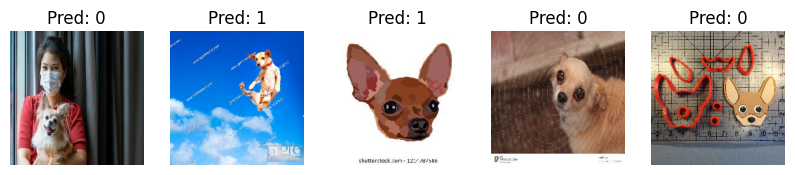

In [13]:
# Plot some predicted images
num_images = 5  # Show 5 images
plt.figure(figsize=(10, 5))

for i in range(num_images):
    plt.subplot(1, num_images, i+1)
    plt.imshow(test_data[i]) 
    plt.title(f"Pred: {y_pred[i][0]}")
    plt.axis("off")
plt.show()

### plot confusion matrix and ROC curve

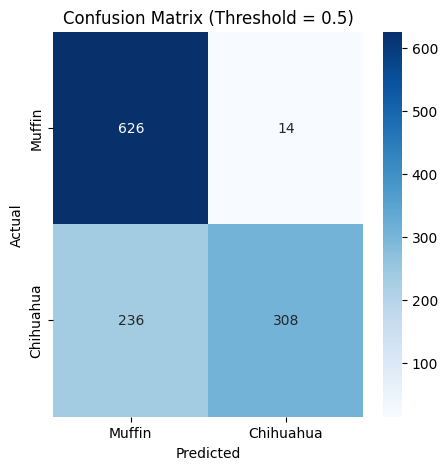

In [14]:
# Create confusion matrix based on y_true, y_pred
matrix = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(5, 5))
sns.heatmap(matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Muffin", "Chihuahua"], yticklabels=["Muffin", "Chihuahua"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (Threshold = 0.5)")
plt.show()

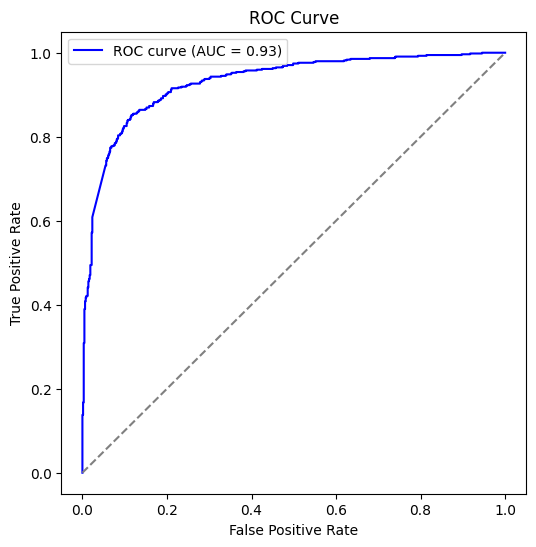

In [15]:
# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)

# Compute AUC
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color="blue", label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--") 
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

In [16]:
# Find the best Threshold np.argmax(tpr - fpr)
best_threshold_idx = np.argmax(tpr - fpr)
best_threshold = thresholds[best_threshold_idx]

print(f"Best Threshold: {best_threshold:.4f}")

Best Threshold: 0.2345


### Calcualte best testhold 

### Plot confusion matrix 

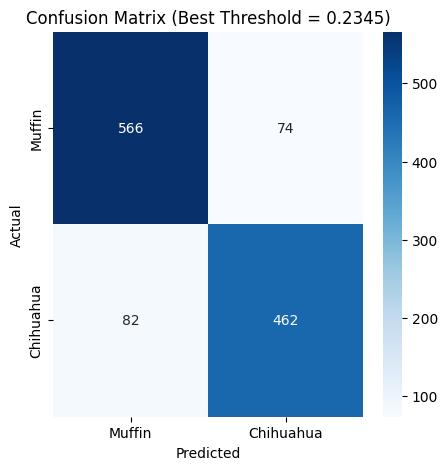

In [17]:
# Apply the best threshold
y_pred_best = (y_pred_prob > best_threshold).astype(int)

# Compute new confusion matrix
matrix = confusion_matrix(y_true, y_pred_best)

# Plot confusion matrix with best threshold
plt.figure(figsize=(5, 5))
sns.heatmap(matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Muffin", "Chihuahua"], yticklabels=["Muffin", "Chihuahua"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title(f"Confusion Matrix (Best Threshold = {best_threshold:.4f})")
plt.show()

##### Confusion Matrix can give a clear picture of false positives, false negatives, and also true positives and true negatives. It helps to analyze the balance between precision and recall. 
##### ROC curve shows how well the model separates positive and negative classes. It helps to find the best threesold rather using a fixed 0.5 thresold ( AUC ~ 1.0 will give perfect classifier, and AUC ~ 0.5 will give radom guessing).